# Vancouver Crime in Relation to Wealth

### Group 13 Project Proposal
#### Introduction

In recent years, the picturesque city of Vancouver has been grappling with a mounting concern as crime, with a notable surge in theft cases, has become an increasingly prevalent issue, posing challenges to the safety and security of its residents. CTV news reported on October 27th of this year that 258 arrests were made in a 2-week period as the Vancouver police department continue the shoplifting crackdown[1]. On October 30th, the B.C. Coalition called for immediate government action on theft, vandalism and violent crime, and its members say they have reached "epidemic proportions'' across the province[2].

Given the prevalent issue, in our project, we will be answering the question: “how do rates of theft differ in different neighbourhoods in Vancouver?”. We will be using the crime data set [3] from 2003 to 2023 released by the VPD, to investigate the number of incidents of robbery, theft of motor vehicles, theft from automotives, and theft under $5,000. The two neighbourhoods we will be comparing the theft rates of are: Strathcona(more commonly known as downtown east side), the poorest neighbourhood in Vancouver, according to Wikipedia[4] and CBC[5],  and Kerrisdale, which is one of the richest neighbourhoods in Vancouver[6][7]. Our location parameter of interest will be the mean value, and our scale parameter of interest will be the standard deviation. We believe that these two parameters will help us answer our question at hand, in comparing the rates of theft of the two neighbourhoods.


In [1]:
# Setup
set.seed(3)

library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
library(GGally)
library(ISLR)
library(ggplot2)
library(gridExtra)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Reading Data

The first step is to read in our data set from the web using the 'read_csv' function. The datasets were originally downloaded from "https://geodash.vpd.ca/opendata", where the data for Kerrisdale and Strathcona were in seperate csv's. So, we read the two csv's seperately and then merged them together into a single data frame using rbind. Our raw dataset also contained a lot of unnecessary columns like the exact time (`MONTH`, `DAY`, `HOUR`, `MINUTE`) and the precise location (`HUNDRED_BLOCK`, `X`, `Y`) of the crime committed, so we selected only the relevant columns to our study such as `TYPE`, `YEAR`, and `NEIGHBOURHOOD`.


In [2]:
# Load the data from the web
kerris_url <- "https://drive.google.com/uc?export=download&id=1XOj_2FTc-0lW5-8RX9lRBOgzX5A2IMet"
strath_url <- "https://drive.google.com/uc?export=download&id=1wXQ8W3kBSo7ija-mhUzCVPbShviQHLNt"
kerrisdale_data <- read_csv(kerris_url)
strathcona_data <- read_csv(strath_url)

# Merge the two data frames into a single data frame:
crime <- rbind(kerrisdale_data, strathcona_data)

# Select only relevant columns to our study
crime <- select(crime, c(TYPE, YEAR, NEIGHBOURHOOD))

print("Table 1: 2003-2023 Crime Data in Kerrisdale and Strathcona")
head(crime)

Rows: 11506 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 56640 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: 2003-2023 Crime Data in Kerrisdale and Strathcona"


TYPE,YEAR,NEIGHBOURHOOD
<chr>,<dbl>,<chr>
Break and Enter Commercial,2017,Kerrisdale
Break and Enter Commercial,2020,Kerrisdale
Break and Enter Commercial,2020,Kerrisdale
Break and Enter Commercial,2007,Kerrisdale
Break and Enter Commercial,2006,Kerrisdale
Break and Enter Commercial,2020,Kerrisdale


#### Cleaning and Wrangling Data
We tidy our data so it follows a consistent format that functions in tidyverse will recognize. We can mutate `NEIGHBOURHOOD` to be a factor to make visualizations and exploratory analysis easier.

In [3]:
#Here we will mutate NEIGHBOURHOOD to a factor so we can visualize it easier
crime_mutate <- crime |>
mutate(NEIGHBOURHOOD = as_factor(NEIGHBOURHOOD))

print("Table 2: Tidy Data")
head(crime_mutate)

[1] "Table 2: Tidy Data"


TYPE,YEAR,NEIGHBOURHOOD
<chr>,<dbl>,<fct>
Break and Enter Commercial,2017,Kerrisdale
Break and Enter Commercial,2020,Kerrisdale
Break and Enter Commercial,2020,Kerrisdale
Break and Enter Commercial,2007,Kerrisdale
Break and Enter Commercial,2006,Kerrisdale
Break and Enter Commercial,2020,Kerrisdale


#### Preliminary exploratory data analysis

To get an idea of the distribution of the crimes committed in both Kerrisdale and Strathcona, we first filter and count by `TYPE` and `YEAR` to get a tally for every crime committed, then we plot the raw data in a stacked bar plot.

In [4]:
# Filter for crimes committed in Kerrisdale
kerrisdale_crimes <- crime_mutate |>
    filter(NEIGHBOURHOOD == "Kerrisdale")

# Filter for crimes committed in Strathcona
strathcona_crimes <- crime_mutate |>
    filter(NEIGHBOURHOOD == "Strathcona")

# Get counts of Kerrisdale crimes
kerrisdale_crime_counts <- kerrisdale_crimes |>
    count(TYPE, YEAR)

# Get counts of Strathcona crimes
strathcona_crime_counts <- strathcona_crimes |>
    count(TYPE, YEAR)
print("Table 3: Kerrisdale Crime Counts")
head(kerrisdale_crime_counts)
print("Table 4: Strathcona Crime Counts")
tail(strathcona_crime_counts)

[1] "Table 3: Kerrisdale Crime Counts"


TYPE,YEAR,n
<chr>,<dbl>,<int>
Break and Enter Commercial,2003,41
Break and Enter Commercial,2004,25
Break and Enter Commercial,2005,34
Break and Enter Commercial,2006,31
Break and Enter Commercial,2007,11
Break and Enter Commercial,2008,26


[1] "Table 4: Strathcona Crime Counts"


TYPE,YEAR,n
<chr>,<dbl>,<int>
Vehicle Collision or Pedestrian Struck (with Injury),2018,88
Vehicle Collision or Pedestrian Struck (with Injury),2019,74
Vehicle Collision or Pedestrian Struck (with Injury),2020,52
Vehicle Collision or Pedestrian Struck (with Injury),2021,56
Vehicle Collision or Pedestrian Struck (with Injury),2022,66
Vehicle Collision or Pedestrian Struck (with Injury),2023,48


Warning message:
“Removed 41 rows containing missing values (`geom_bar()`).”


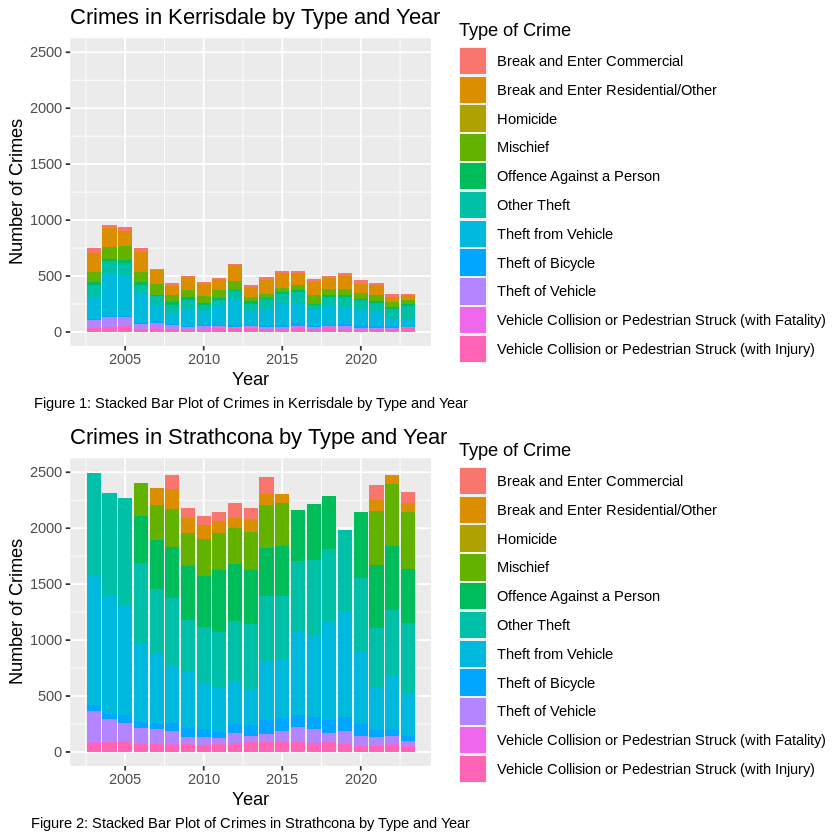

In [13]:
# Create stacked bar plot of raw data for Kerrisdale
kerrisdale_raw_data_plot <- kerrisdale_crime_counts |>
    ggplot(aes(x = YEAR, y = n, fill = TYPE)) +
    geom_bar(stat = "identity") +
    labs(x = "Year", y = "Number of Crimes", fill = "Type of Crime", caption = "Figure 1: Stacked Bar Plot of Crimes in Kerrisdale by Type and Year") +
    ggtitle("Crimes in Kerrisdale by Type and Year") +
    ylim(0, 2500) + theme(plot.caption = element_text(hjust = 0.5))

# Create stacked bar plot of raw data for Strathcona
strathcona_raw_data_plot <- strathcona_crime_counts |>
    ggplot(aes(x = YEAR, y = n, fill = TYPE)) +
    geom_bar(stat = "identity") +
    labs(x = "Year", y = "Number of Crimes", fill = "Type of Crime", caption = "Figure 2: Stacked Bar Plot of Crimes in Strathcona by Type and Year") +
    ggtitle("Crimes in Strathcona by Type and Year") +
    ylim(0, 2500) + theme(plot.caption = element_text(hjust = 0.5))

# Display plots
grid.arrange(kerrisdale_raw_data_plot, strathcona_raw_data_plot)

Now, to calculate the proportion of thefts, we group the data into thefts and non-thefts. Our new column, `Theft` includes the following theft-related crimes: "Theft of Bicycle", "Theft of Vehicle", "Theft from Vehicle", and "Other Theft". Non-theft related crimes are under the column `Other`, which includes crimes such as "Break and Enter Commercial", "Homicide", among others.  

We can then plot a sample distribution of the proportions of theft.

In [6]:
kerrisdale_crimes_grouped <- kerrisdale_crimes |>
    mutate(TYPE = ifelse(TYPE %in% c("Theft of Bicycle", "Theft of Vehicle", "Theft from Vehicle", "Other Theft"),
                         "Theft", "Other"))

strathcona_crimes_grouped <- strathcona_crimes |>
    mutate(TYPE = ifelse(TYPE %in% c("Theft of Bicycle", "Theft of Vehicle", "Theft from Vehicle", "Other Theft"),
                         "Theft", "Other"))

kerrisdale_yearly_proportions <- kerrisdale_crimes_grouped |>
    group_by(YEAR, TYPE) |>
    summarise(count = n()) |>
    spread(TYPE, count, fill = 0) |>
    mutate(Proportion = Theft / (Theft + Other))

strathcona_yearly_proportions <- strathcona_crimes_grouped |>
    group_by(YEAR, TYPE) |>
    summarise(count = n()) |>
    spread(TYPE, count, fill = 0) |>
    mutate(Proportion = Theft / (Theft + Other))

print("Table 5: Kerrisdale Proportion of Theft by Year")
kerrisdale_yearly_proportions

print("Table 6: Kerrisdale Proportion of Theft by Year")
strathcona_yearly_proportions

`summarise()` has grouped output by 'YEAR'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'YEAR'. You can override using the
`.groups` argument.


[1] "Table 5: Kerrisdale Proportion of Theft by Year"


YEAR,Other,Theft,Proportion
<dbl>,<dbl>,<dbl>,<dbl>
2003,362,385,0.5153949
2004,363,592,0.6198953
2005,370,569,0.6059638
⋮,⋮,⋮,⋮
2021,201,233,0.5368664
2022,160,179,0.5280236
2023,142,195,0.5786350


[1] "Table 6: Kerrisdale Proportion of Theft by Year"


YEAR,Other,Theft,Proportion
<dbl>,<dbl>,<dbl>,<dbl>
2003,1112,2407,0.6840011
2004,1210,2229,0.6481535
2005,1148,2172,0.6542169
⋮,⋮,⋮,⋮
2021,1332,1052,0.4412752
2022,1410,1199,0.4595631
2023,1220,1105,0.4752688


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


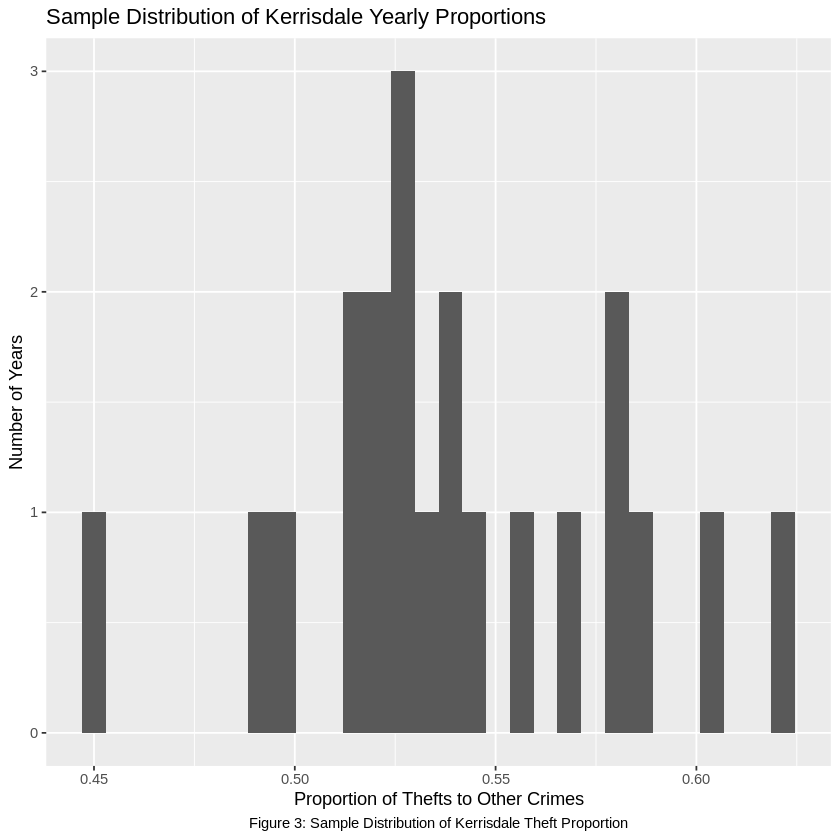

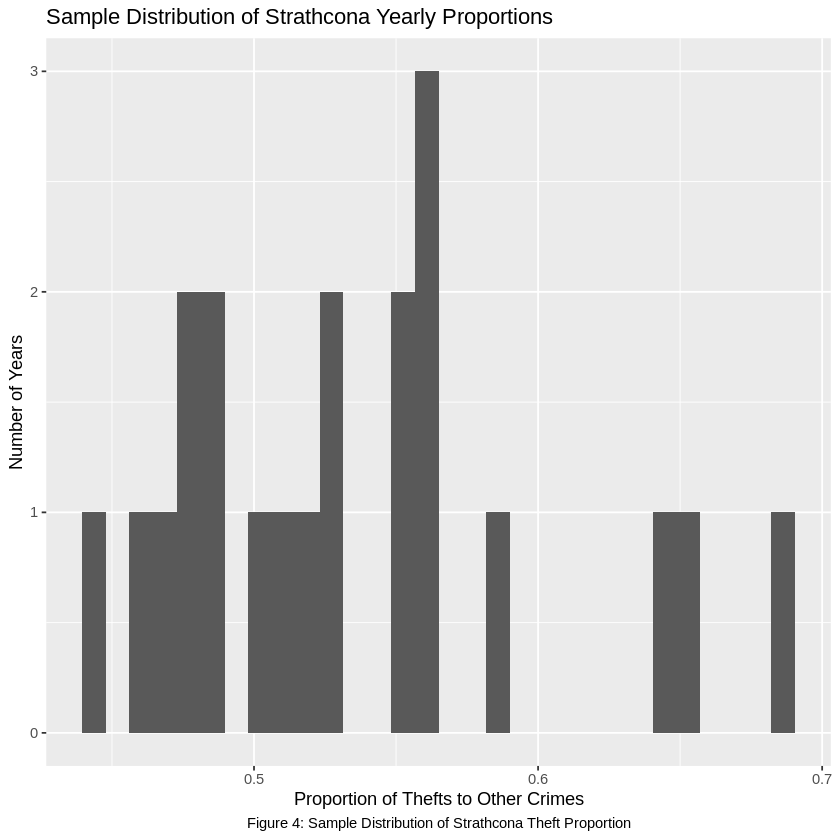

In [12]:
kerrisdale_distribution <- kerrisdale_yearly_proportions |>
    ggplot(aes(x = Proportion)) +
    geom_histogram() +
    labs(x = "Proportion of Thefts to Other Crimes", y = "Number of Years", caption = "Figure 3: Sample Distribution of Kerrisdale Theft Proportion") +
    ggtitle("Sample Distribution of Kerrisdale Yearly Proportions") + theme(plot.caption = element_text(hjust = 0.5))

strathcona_distribution <- strathcona_yearly_proportions |>
    ggplot(aes(x = Proportion)) +
    geom_histogram() +
    labs(x = "Proportion of Thefts to Other Crimes", y = "Number of Years", caption = "Figure 4: Sample Distribution of Strathcona Theft Proportion") +
    ggtitle("Sample Distribution of Strathcona Yearly Proportions") + theme(plot.caption = element_text(hjust = 0.5))

kerrisdale_distribution
strathcona_distribution

#### Parameter Estimates

First, we'll find the standard deviation of proportions between years.

In [8]:
kerrisdale_sd <- sd(kerrisdale_yearly_proportions$Proportion)
strathcona_sd <- sd(strathcona_yearly_proportions$Proportion)

print(paste("Kerrisdale Standard Deviation:", kerrisdale_sd))
print(paste("Strathcona Standard Deviation:", strathcona_sd))

[1] "Kerrisdale Standard Deviation: 0.0401894065847055"
[1] "Strathcona Standard Deviation: 0.0659204360404515"


Now, we'll find the total proportions for Kerrisdale and Strathcona across all the years.

In [9]:
kerrisdale_totals <- kerrisdale_crimes_grouped |>
    count(TYPE)

strathcona_totals <- strathcona_crimes_grouped |>
    count(TYPE)

# Kerrisdale Sample Size
n1 <- kerrisdale_totals$n[1] + kerrisdale_totals$n[2]

# Kerrisdale Proportion
p1 <- kerrisdale_totals$n[2] / n1

# Strathcona Sample Size
n2 <- strathcona_totals$n[1] + strathcona_totals$n[2]

# Strathcona Proportion
p2 <- strathcona_totals$n[2] / n2

print(paste("Kerrisdale Sample Size:", n1, ", Kerrisdale Proportion:", p1))
print(paste("Strathcona Sample Size:", n2, ", Strathcona Proportion:", p2))

[1] "Kerrisdale Sample Size: 11506 , Kerrisdale Proportion: 0.545193811924213"
[1] "Strathcona Sample Size: 56640 , Strathcona Proportion: 0.543290960451977"


Now, we can calculate the difference between Kerrisdale's and Strathcona's total proportions.

In [10]:
# Calculate the difference in total proportions
diff_in_props <- abs(p1 - p2)

print(paste("Difference in total proportions", diff_in_props))

[1] "Difference in total proportions 0.00190285147223601"


#### Methods
#### Expected outcomes and significance:
- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?

#### References
[1] : https://bc.ctvnews.ca/258-arrests-made-in-2-week-period-as-vancouver-police-continue-shoplifting-crackdown-1.6620249

[2] : https://www.cbc.ca/news/canada/british-columbia/save-our-streets-seeks-crackdown-on-violent-retail-crimes-1.7013229

[3]: https://geodash.vpd.ca/opendata/#   *Source of Our Data

[4]: https://en.wikipedia.org/wiki/Downtown_Eastside#:~:text=The%20Downtown%20Eastside%20(DTES)%20is,mental%20illness%20and%20sex%20work.

[5]: https://www.cbc.ca/news/canada/british-columbia/weighing-in-on-future-of-vancouver-s-downtown-eastside-1.1356400

[6]: https://www.thebestvancouver.com/where-do-rich-in-vancouver-live/

[7]: https://www.cantechletter.com/2023/07/the-five-wealthiest-neighbourhoods-in-vancouver-listed/